# Classification
#### Sources: Hands-on Machine Learning with Scikit-Learn, Keras, and Tensorflow, 2nd Edition by Aurelien Geron Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9
#### in this section we will use mnist dataset and classify this dataset of handwritten images

### We will use the following code from scikit-learn to import this dataset.
#### .keys() will give us all keys in the dictonary:
##### - DESCR describes the dataset, data key contains an array with one row per instance, target key gives us the array with labels for our mnist dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

#### Let us take a look at these datasets we can see from our keys

In [2]:
X, y= mnist["data"], mnist["target"]
print("Input data shape: ", X.shape)
print("Label shape: ", y.shape)

Input data shape:  (70000, 784)
Label shape:  (70000,)


### We can see from the above code that our data has 70k rows of data with 784 inputs. These 784 inputs represent a 28 x 28 grid representing our pixels on a screen

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

### Looks like a five but lets check what it actually says it is

In [4]:
y[0]

'5'

In [5]:
import numpy as np
y = y.astype(np.uint8)
type(y)

numpy.ndarray

### Mnist dataset is already shuffled for us and already split in to the training set (first 60,000 images) and test set (the last 10,000 images)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000], y[60000:]

### Lets first simplify the problem and try to only identify whether a number is a five or not a five.

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test ==5)

### We are going to now pick stochastic gradient descent classifier and train it. SGD works well on larger datasets because it picks few random points rather than iterating through the whole dataset.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### Now we use the model to predict

In [9]:
sgd_clf.predict([some_digit])

array([ True])

### Sometimes you will need more control over the cross-fold validation and might need to implement it yourself

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Stratified k fold will give us three folds that equally represent the dataset (stratified)
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    #lets get a deep copy of the original sgd classifier we created before
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


### to evaluate our sgd classifier we can use the cross_val_score() to evaluate the performance

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### As you can see that even if we make a classifier that always guesses not a 5 we get above 90% accuracy. Accuracy with classifiers should always be evaluated.

## Confusion Matrix
### To dive deeper into where errors are occurring sometimes it is useful to look at the confusion matrix of predictions. This will help you for example see where 5s are being classified as 3s or any other number. We can specifically see where our model is failing

In [13]:
from sklearn.model_selection import cross_val_predict

'''we will use cross_val_predict and just like cross_val_score it performs cross-validation but instead of 
returning the evaluation scores it returns the predictions made for each fold
'''
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## [true-negative, false-positive],
## [false-negative, true-positive]

### true-negative - guessed false and was actually false
### false-positive - guessed true and was actually false
### false-negative - guessed false and was actually true
### true-positive - guessed true and was actually true

### precision = TP / (TP + FP)
### recall = TP / (TP + FN)

In [15]:
# now we can use library from sklearn to calculate precision and recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

### it is often helpful to combine recall and precision into one score called F1. This will be helpful to compare two classifiers.

### F1 = 2/((1/precision) + (1/recall)) = 2*((precision*recall)/(precision+recall)) = (TP)/(TP + ((FN + FP)/2))

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### The ROC Curve
#### receiver operating characteristic - plots the true positive rate (aka recall) against the false positive rate. Ratio of negative instances that are incorrectly classified as positive (1- true negative rate)

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_train_pred)

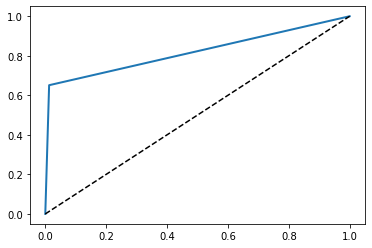

In [19]:
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.show()

### Multiclass Classification
#### binary classifiers distinguish between two classes, multiclass classifiers called mutlinomial classifiers distinguish between more than two classes. SGD classifiers, Random Forest, and naive Bayes can handle multiple class. Logistic regression and support vector machine classifiers are strictly binary

#### you can also create multiclass classifier from multiple binary classifiers

### OvR strategy one versus the rest
#### create a detector for each class. 0,1,2,3,4,5,etc and then select the class whose classifier outputs the highest score

### OvO one versus one strategy
#### for n classes you need n * (n-1) / 2 classifiers. Basically classes duel against each other and whichever class wins the most duels is chosen. Example: 0 vs 1, 0 vs 2, ... 9 vs 8

### Multioutput classification
#### multioutput multiclass classification is simply a generalization of multilabel classification where each label can be a multiclass. ie can have more than two possible values

#### add noise to an image and try to get back original

In [20]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

In [26]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

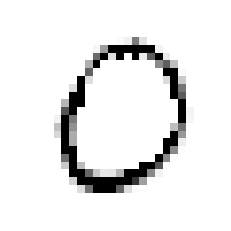

In [27]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[10]])
plot_digit(clean_digit)